# Computer Vision for CIFAR via CNN

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

## Form dataloader

In [119]:
import torchvision.transforms as transforms

# image_size = 64

transform = transforms.Compose(
    [       
            transforms.ToTensor(),
            # transforms.Resize(image_size),
            # transforms.RandomResizedCrop(image_size),
            transforms.Normalize(mean=(0.5), std=(0.5))
     ]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Print class instances

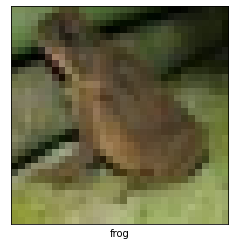

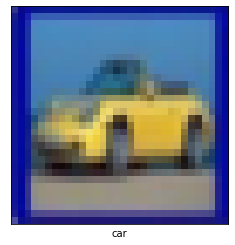

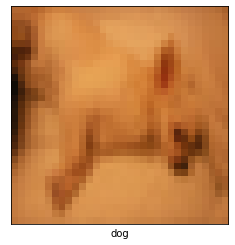

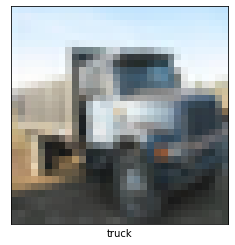

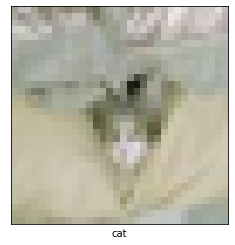

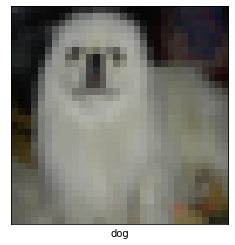

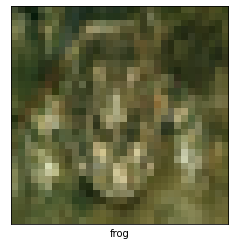

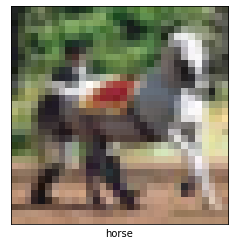

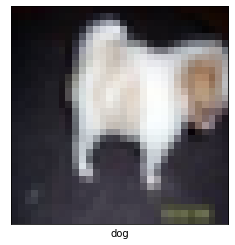

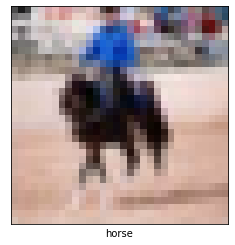

In [131]:
import torchvision.datasets as datasets

class_names = ['airplane', 'car','bird', 'cat','deer','dog','frog','horse','ship','truck']

dataiter = iter(trainloader)
images, labels = dataiter.next()

for i in range(10):
    plt.xticks([])
    plt.yticks([])
    img = images[i] / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xlabel(class_names[labels[i]])
    plt.show()



## Model

In [126]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1), 
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.MaxPool2d(kernel_size=2),
  
            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.MaxPool2d(kernel_size=2),
              
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.MaxPool2d(kernel_size=2),
  
            torch.nn.Flatten(),
            torch.nn.Linear(64*4*4, 512),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(512, 10)
        )
  
  def forward(self, x):
        return self.model(x)

net = Net()

## Optimizar and loss function

In [127]:
import torch.optim as optim

epoches = 20
batch_size = 128
base_lr = 0.001
beta1 = 0.5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=base_lr, betas=(beta1, 0.999))

scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

## Training

In [128]:
for epoch in range(epoches): 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 250 == 249:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 249:.3f}')
            running_loss = 0.0
    
    scheduler1.step()

print('Finished Training')

[1,   250] loss: 1.532
[2,   250] loss: 1.026
[3,   250] loss: 0.816
[4,   250] loss: 0.678
[5,   250] loss: 0.576
[6,   250] loss: 0.488
[7,   250] loss: 0.415
[8,   250] loss: 0.348
[9,   250] loss: 0.282
[10,   250] loss: 0.233
[11,   250] loss: 0.186
[12,   250] loss: 0.152
[13,   250] loss: 0.118
[14,   250] loss: 0.091
[15,   250] loss: 0.069
[16,   250] loss: 0.053
[17,   250] loss: 0.039
[18,   250] loss: 0.031
[19,   250] loss: 0.024
[20,   250] loss: 0.017
Finished Training




---



## Testing on Val set

In [129]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 75 %


In [130]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 79.4 %
Accuracy for class: car   is 85.8 %
Accuracy for class: bird  is 69.3 %
Accuracy for class: cat   is 60.4 %
Accuracy for class: deer  is 69.3 %
Accuracy for class: dog   is 63.3 %
Accuracy for class: frog  is 83.3 %
Accuracy for class: horse is 80.4 %
Accuracy for class: ship  is 86.4 %
Accuracy for class: truck is 80.7 %


## Save model

In [132]:
torch.save(net.state_dict(), 'model.pth')